## Dataset
### Importing the libraries

In [50]:
import graphviz
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, make_scorer
from sklearn.ensemble import RandomForestClassifier

### Prepare the dataset
- 212 malignant instances   = class 0
- 359 benign instances      = class 1

In [51]:
data = load_breast_cancer()
feature_matrix = data.data  # Feature matrix
class_vector = data.target  # Class vector

## Tasks
### First Inspections on the Dataset and Preprocessing
#### D1 Scatter plot of first 10 features

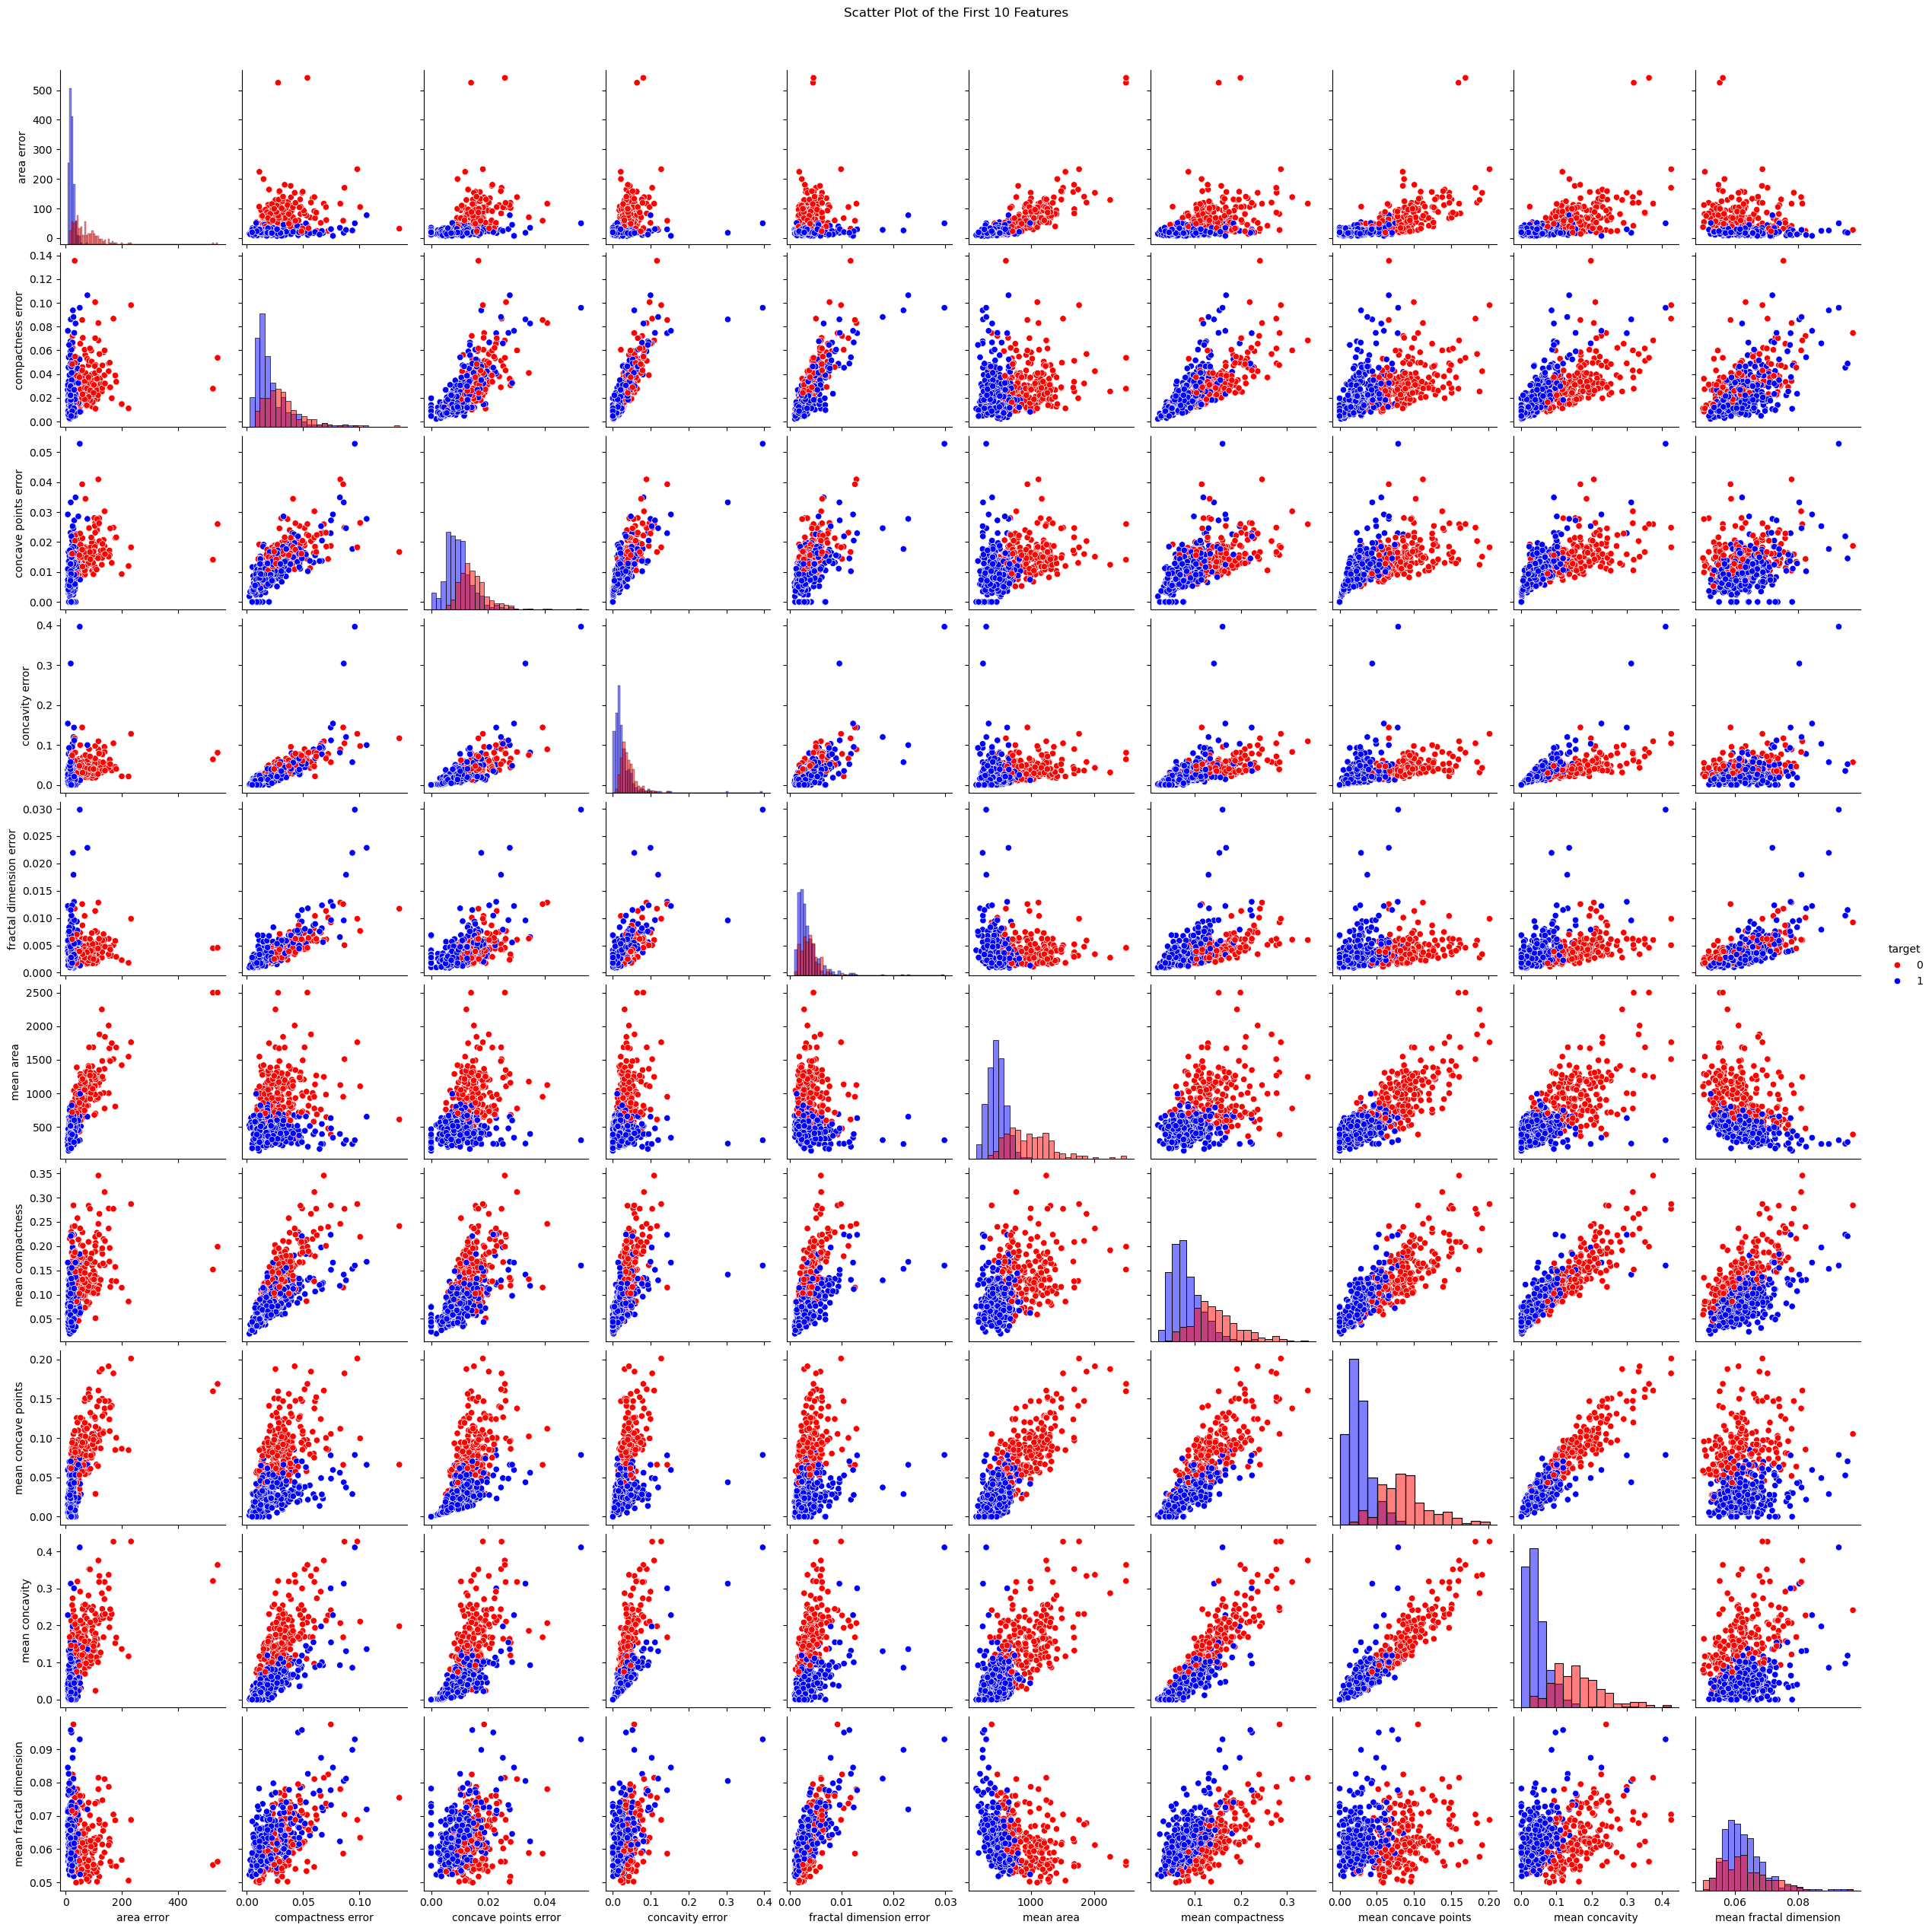

In [52]:
# DataFrame for the feature matrix
df = pd.DataFrame(feature_matrix, columns=data.feature_names)
df = df.reindex(sorted(df.columns), axis=1)

# DataFrame with only the first 10 features
df_first10 = df.iloc[:, :10].copy()
df_first10['target'] = class_vector

# Plot the scatter plot of the first 10 features
colors = {0: 'red', 1: 'blue'}
scatter_matrix = sns.pairplot(df_first10, hue='target', palette=colors, diag_kind='hist')
scatter_matrix.figure.suptitle('Scatter Plot of the First 10 Features', y=1.02)
plt.show()


#### D3 Correlation Matrix Heatmap

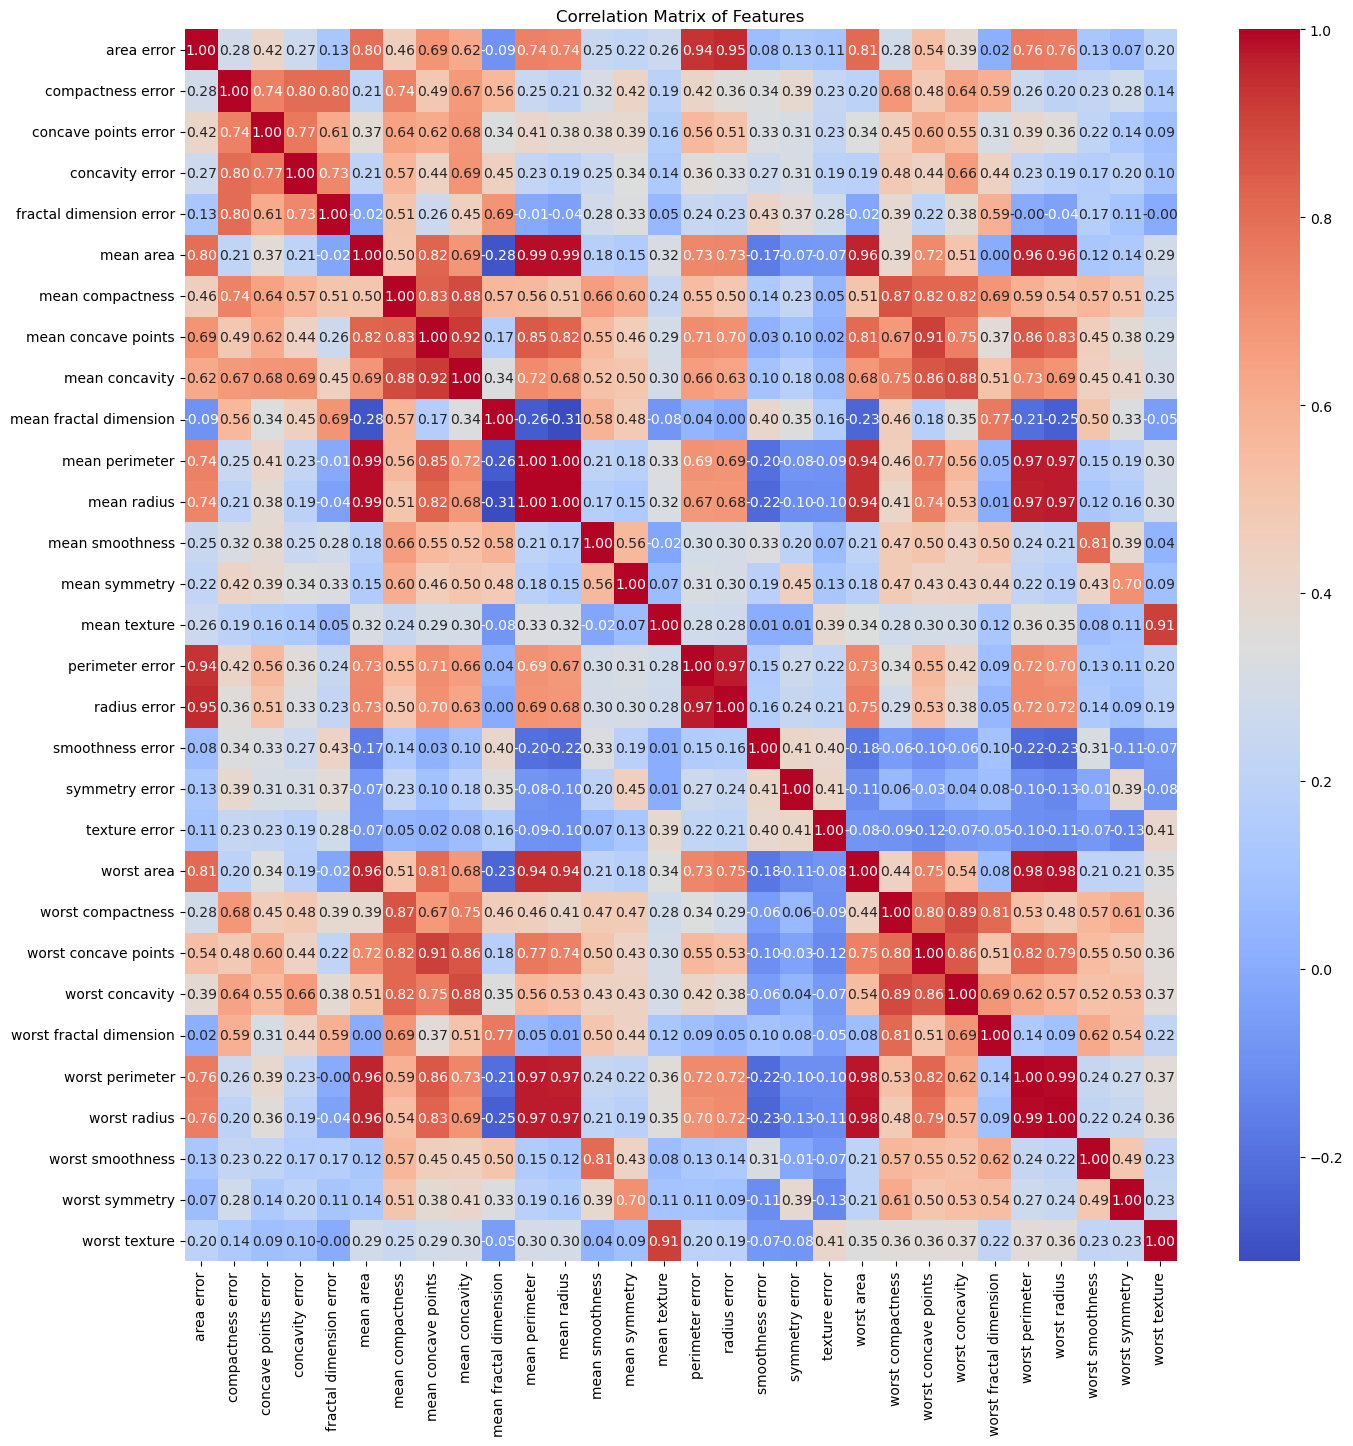

In [53]:
# Compute the correlation matrix
corr_matrix = df.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(16, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

#### D5 Drop features with a linear correlation higher that 0.97

In [54]:
# List of highly correlated features to drop
features_to_drop = ['mean perimeter', 'mean radius', 'worst radius', 'worst perimeter', 'radius error']

# Feature matrix and class vector with dropped highly correlated features
X = df.copy()
X = X.drop(columns=features_to_drop)
y = class_vector

### Fitting a Decision Tree model with default hyperparameters
#### D6 Decision Tree model performance

In [55]:
# Function to fit a decision tree classifier and make predictions
# Returns the decision tree classifier, accuracy, precision, recall scores (both sets)
# Returns the confusion matrix (test set)
def decision_tree_classifier(X_train, y_train, X_test, y_test, params=None):
    if params is None:
        # Fit a decision tree classifier with default parameters
        dt_classifier = DecisionTreeClassifier(random_state=5508)
    else:
        # Fit a decision tree classifier with hyperparameters tuning
        dt_classifier = DecisionTreeClassifier(random_state=5508, **params)
    
    dt_classifier.fit(X_train, y_train)
    
    # Make predictions on the training and test sets
    y_pred_train = dt_classifier.predict(X_train)
    y_pred_test = dt_classifier.predict(X_test)
    
    # Compute the accuracy, precision, and recall scores for both sets
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    precision_train = precision_score(y_train, y_pred_train)
    precision_test = precision_score(y_test, y_pred_test)
    recall_train = recall_score(y_train, y_pred_train)
    recall_test = recall_score(y_test, y_pred_test)
    
    # Compute the confusion matrix for the test set
    conf_matrix = confusion_matrix(y_test, y_pred_test)
    
    return dt_classifier, accuracy_train, accuracy_test, precision_train, precision_test, recall_train, recall_test, conf_matrix

# Function to print the confusion matrix with class names
def print_confusion_matrix(cm):
    tn, fp, fn, tp = cm.ravel()
    confusion_matrix = np.array([[tp, fp], [fn, tn]])
    predicted = ['Predicted Positive', 'Predicted Negative']
    actual = ['Actual Positive', 'Actual Negative']
    df_cm = pd.DataFrame(confusion_matrix, index=predicted, columns=actual)
    print(df_cm)

In [56]:
# Fit a decision tree classifier with random state 5508
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=5508)

dt_5508, accuracy_train, accuracy_test, precision_train, \
precision_test, recall_train, recall_test, conf_matrix \
    = decision_tree_classifier(train_x, train_y, test_x, test_y)
    
# Print the results
print("Training Set")
print("Accuracy  :", round(accuracy_train, 2))
print("Precision :", round(precision_train, 2))
print("Recall    :", round(recall_train, 2))
print("====================================================")
print("Test Set")
print("Accuracy  :", round(accuracy_test, 2))
print("Precision :", round(precision_test, 2))
print("Recall    :", round(recall_test, 2))
print("Confusion Matrix:")
print_confusion_matrix(conf_matrix)


Training Set
Accuracy  : 1.0
Precision : 1.0
Recall    : 1.0
Test Set
Accuracy  : 0.96
Precision : 0.97
Recall    : 0.97
Confusion Matrix:
                    Actual Positive  Actual Negative
Predicted Positive               71                2
Predicted Negative                2               39


#### D8 Display Decision Tree from D6

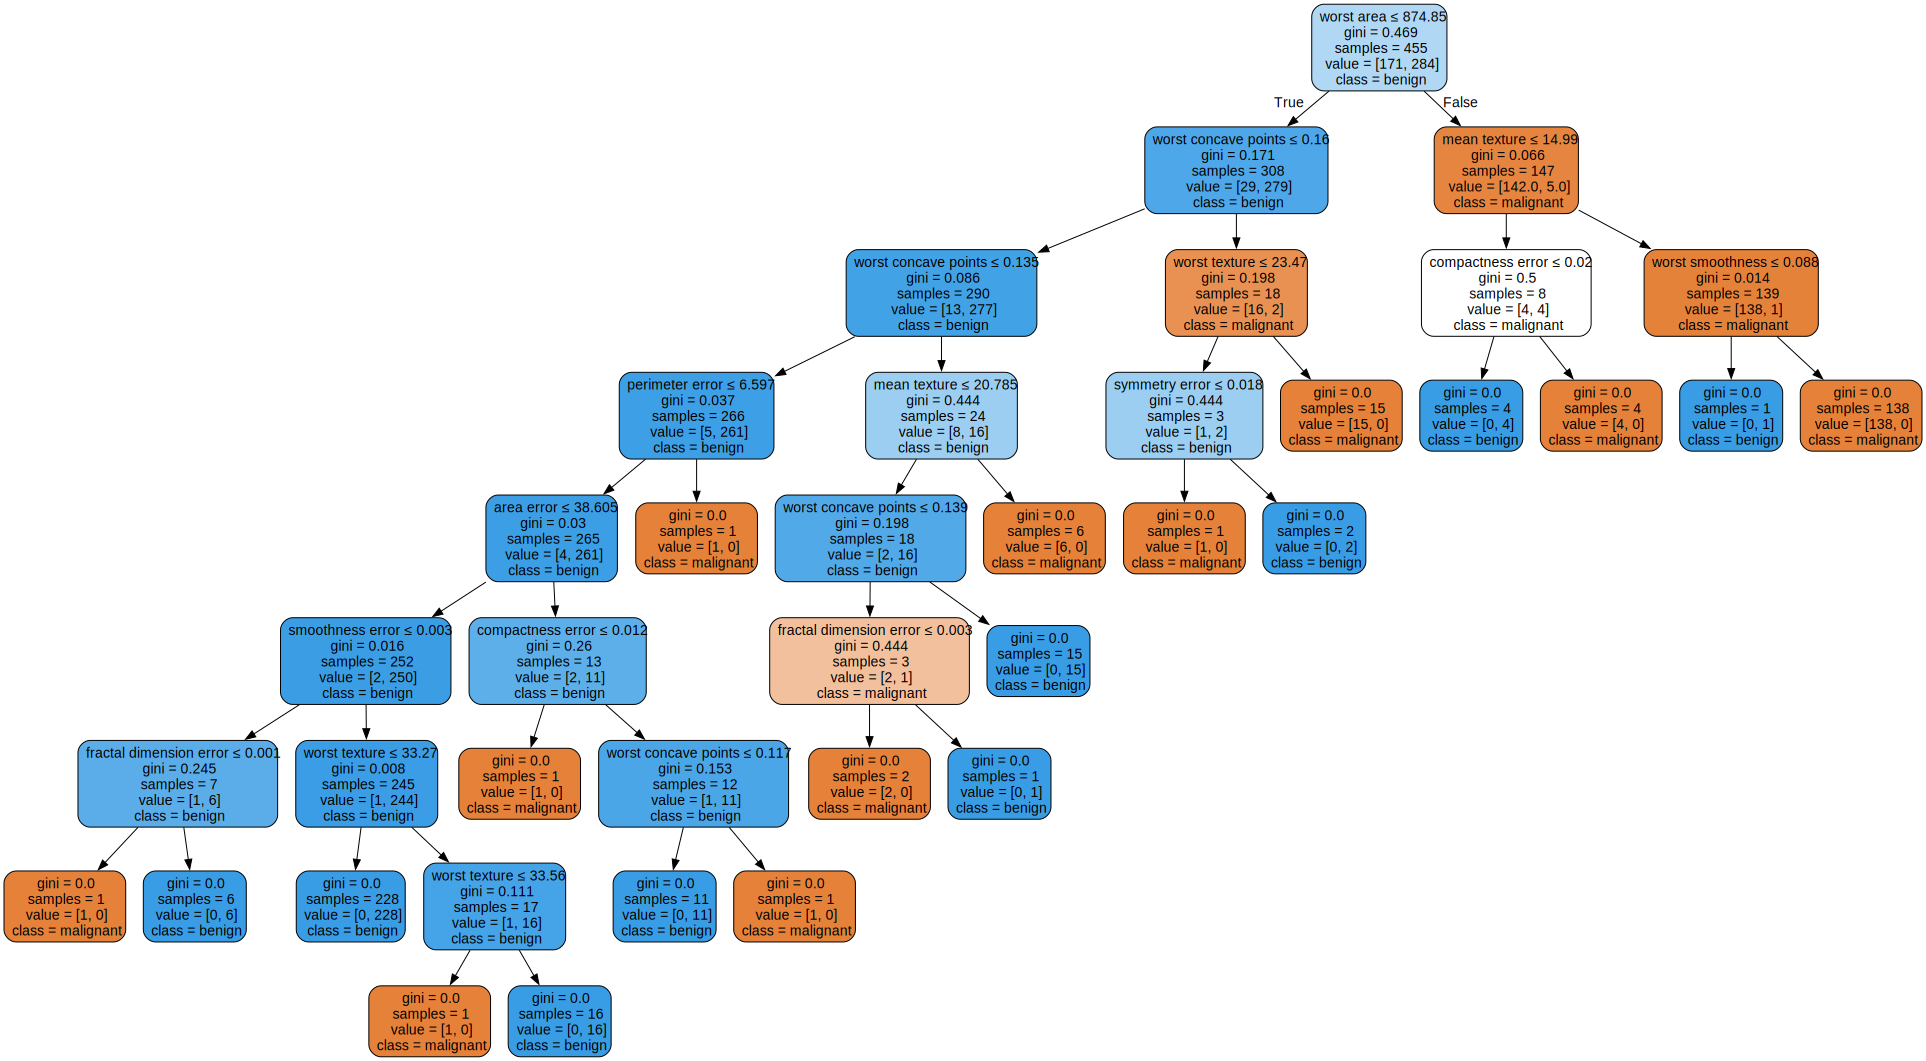

In [57]:
# Display the decision tree from D6
dot_data = tree.export_graphviz(dt_5508, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("Breast Cancer")
 
dot_data = tree.export_graphviz(dt_5508, out_file=None, 
                     feature_names=X.columns,  
                     class_names=['malignant', 'benign'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

#### D10 Five different data split random states and their Decision Tree model scores

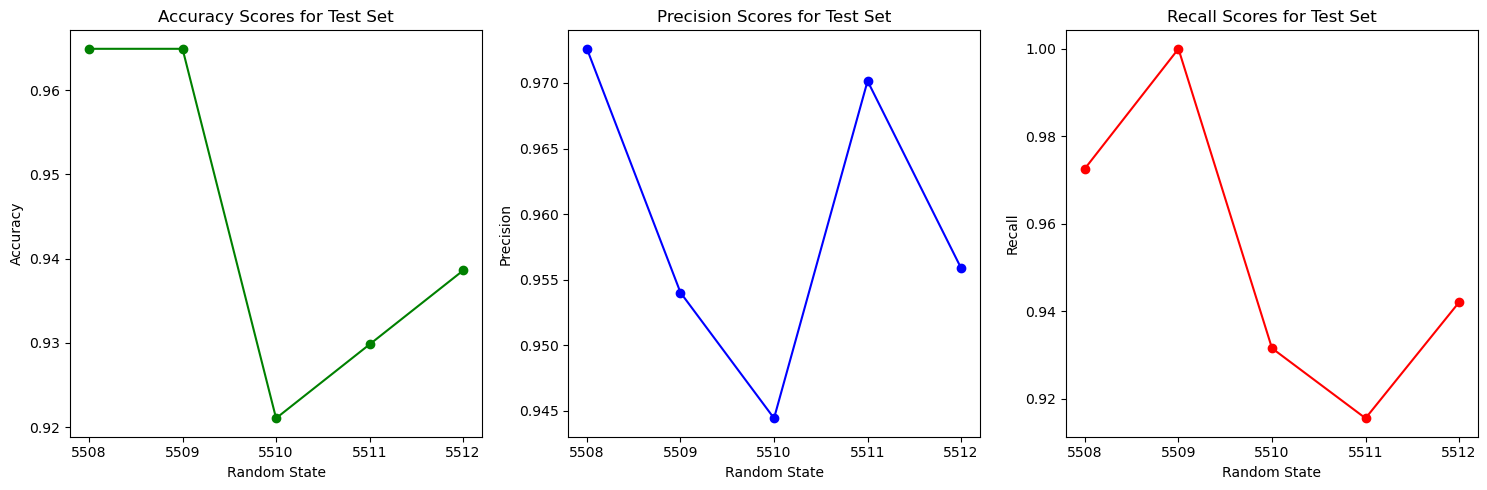

In [58]:
# Split the data into training and testing sets for different random states
random_states = [5508, 5509, 5510, 5511, 5512]
state_xlabels = ["5508", "5509", "5510", "5511", "5512"]
accuracy_scores, precision_scores, recall_scores = [], [], []

for state in random_states:
    # Split the data into training and testing sets for the current random state
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=state)

    # Fit a decision tree classifier with the current random state
    _, _, accuracy_test, _, precision_test, _, recall_test, _ = decision_tree_classifier(train_x, train_y, test_x, test_y)

    # Append the scores to the lists
    accuracy_scores.append(accuracy_test)
    precision_scores.append(precision_test)
    recall_scores.append(recall_test)

# Plot the accuracy, precision, and recall scores on the test set for different random states
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(state_xlabels, accuracy_scores, marker='o', color='green')
plt.title('Accuracy Scores for Test Set')
plt.xlabel('Random State')
plt.ylabel('Accuracy')

plt.subplot(1, 3, 2)
plt.plot(state_xlabels, precision_scores, marker='o', color='blue')
plt.title('Precision Scores for Test Set')
plt.xlabel('Random State')
plt.ylabel('Precision')

plt.subplot(1, 3, 3)
plt.plot(state_xlabels, recall_scores, marker='o', color='red')
plt.title('Recall Scores for Test Set')
plt.xlabel('Random State')
plt.ylabel('Recall')

plt.tight_layout()
plt.show()

#### D11 Five different data split sizes and their Decision Tree model scores

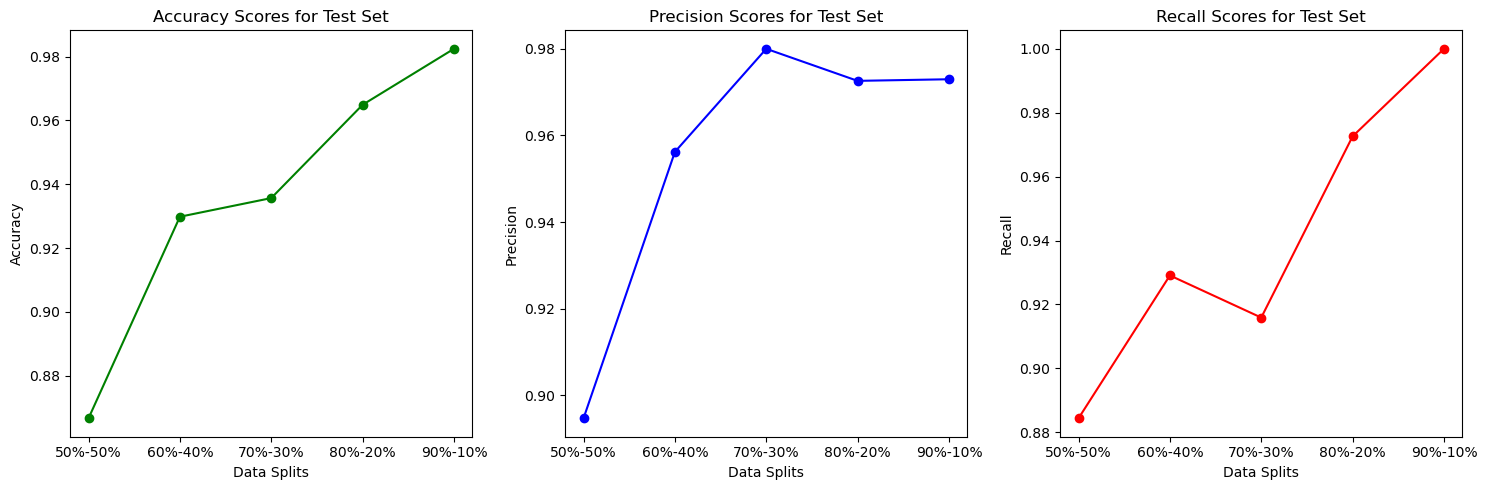

In [59]:
# Split the data into training and testing sets for different sizes
STATE = 5508
split_sizes = [0.5, 0.4, 0.3, 0.2, 0.1]
split_xlabels = [f"{int((1-size)*100)}%-{int(size*100)}%" for size in split_sizes]
accuracy_scores, precision_scores, recall_scores = [], [], []

for size in split_sizes:
    # Split the data into training and testing sets for the current size
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=size, random_state=STATE)

    # Fit a decision tree classifier with the current training size
    _, _, accuracy_test, _, precision_test, _, recall_test, _ = decision_tree_classifier(train_x, train_y, test_x, test_y)

    # Append the scores to the lists
    accuracy_scores.append(accuracy_test)
    precision_scores.append(precision_test)
    recall_scores.append(recall_test)

# Plot the accuracy, precision, and recall scores on the test set for different training sizes
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(split_xlabels, accuracy_scores, marker='o', color='green')
plt.title('Accuracy Scores for Test Set')
plt.xlabel('Data Splits')
plt.ylabel('Accuracy')

plt.subplot(1, 3, 2)
plt.plot(split_xlabels, precision_scores, marker='o', color='blue')
plt.title('Precision Scores for Test Set')
plt.xlabel('Data Splits')
plt.ylabel('Precision')

plt.subplot(1, 3, 3)
plt.plot(split_xlabels, recall_scores, marker='o', color='red')
plt.title('Recall Scores for Test Set')
plt.xlabel('Data Splits')
plt.ylabel('Recall')

plt.tight_layout()
plt.show()

### Fitting a Decision Tree model with optimal hyperparameters
#### D12 Decision Tree model performance

In [60]:
# Function to print results for a decision tree classifier
def print_results(optimal_params, accuracy_train, accuracy_test, precision_train, precision_test, recall_train, recall_test, conf_matrix):
    print("Optimal Hyperparameters ---------------------------------")
    for key, value in optimal_params.items():
        print(f"{key}\t: {value}")
    print("Training Set ---------------------------------------")
    print("Accuracy  :", round(accuracy_train, 2))
    print("Precision :", round(precision_train, 2))
    print("Recall    :", round(recall_train, 2))
    print("Test Set -------------------------------------------")
    print("Accuracy  :", round(accuracy_test, 2))
    print("Precision :", round(precision_test, 2))
    print("Recall    :", round(recall_test, 2))
    print("Confusion Matrix:")
    print_confusion_matrix(conf_matrix)

In [61]:
# Split the data into training and testing sets 80%-20% random state 5508
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=5508)

# Perform grid search with 10-fold cross-validation for Decision Tree model
param_grid_dt = {
    'max_depth': [2, 3, 4, 5],
    'min_samples_split': [2, 4, 5, 10],
    'min_samples_leaf': [2, 5]
}
dt_classifier = DecisionTreeClassifier(random_state=42)
grid_search_accuracy = GridSearchCV(estimator=dt_classifier, param_grid=param_grid_dt, scoring='accuracy', cv=10)
grid_search_accuracy.fit(train_x, train_y)

# Get the best hyperparameters
best_params_accuracy = grid_search_accuracy.best_params_

# Retrain the decision tree classifier with the optimal hyperparameters
dt_complete, accuracy_train_complete, accuracy_test_complete, precision_train_complete, \
precision_test_complete, recall_train_complete, recall_test_complete, conf_matrix_complete \
    = decision_tree_classifier(train_x, train_y, test_x, test_y, params=best_params_accuracy)

# Print the results
print_results(best_params_accuracy, accuracy_train_complete, accuracy_test_complete, precision_train_complete, 
              precision_test_complete, recall_train_complete, recall_test_complete, conf_matrix_complete)

Optimal Hyperparameters ---------------------------------
max_depth	: 4
min_samples_leaf	: 5
min_samples_split	: 2
Training Set ---------------------------------------
Accuracy  : 0.97
Precision : 0.98
Recall    : 0.98
Test Set -------------------------------------------
Accuracy  : 0.95
Precision : 0.97
Recall    : 0.95
Confusion Matrix:
                    Actual Positive  Actual Negative
Predicted Positive               69                2
Predicted Negative                4               39


#### D14 Grid Search with scoring 'accuracy', 'precision', and 'recall

In [62]:
# Define custom scorers for precision and recall
scoring_precision = make_scorer(precision_score, average='binary')
scoring_recall = make_scorer(recall_score, average='binary')

# Repeat task D12 for precision
grid_search_precision = GridSearchCV(estimator=dt_classifier, param_grid=param_grid_dt, scoring=scoring_precision, cv=10)
grid_search_precision.fit(train_x, train_y)
best_params_precision = grid_search_precision.best_params_
dt_precision, _, _, _, _, _, _, conf_matrix_precision = decision_tree_classifier(train_x, train_y, test_x, test_y, params=best_params_precision)

# Repeat task D12 for recall
grid_search_recall = GridSearchCV(estimator=dt_classifier, param_grid=param_grid_dt, scoring=scoring_recall, cv=10)
grid_search_recall.fit(train_x, train_y)
best_params_recall = grid_search_recall.best_params_
dt_recall, _, _, _, _, _, _, conf_matrix_recall = decision_tree_classifier(train_x, train_y, test_x, test_y, params=best_params_recall)

# Print the results
print("Accuracy")
print("max_depth         :", best_params_accuracy['max_depth'])
print("min_samples_leaf  :", best_params_accuracy['min_samples_leaf'])
print("min_samples_split :", best_params_accuracy['min_samples_split'])
print("Confusion Matrix:")
print_confusion_matrix(conf_matrix_complete)
print("====================================================")
print("Precision")
print("max_depth         :", best_params_precision['max_depth'])
print("min_samples_leaf  :", best_params_precision['min_samples_leaf'])
print("min_samples_split :", best_params_precision['min_samples_split'])
print("Confusion Matrix:")
print_confusion_matrix(conf_matrix_precision)
print("====================================================")
print("Recall")
print("max_depth         :", best_params_recall['max_depth'])
print("min_samples_leaf  :", best_params_recall['min_samples_leaf'])
print("min_samples_split :", best_params_recall['min_samples_split'])
print("Confusion Matrix:")
print_confusion_matrix(conf_matrix_recall)

Accuracy
max_depth         : 4
min_samples_leaf  : 5
min_samples_split : 2
Confusion Matrix:
                    Actual Positive  Actual Negative
Predicted Positive               69                2
Predicted Negative                4               39
Precision
max_depth         : 5
min_samples_leaf  : 2
min_samples_split : 5
Confusion Matrix:
                    Actual Positive  Actual Negative
Predicted Positive               68                2
Predicted Negative                5               39
Recall
max_depth         : 3
min_samples_leaf  : 5
min_samples_split : 2
Confusion Matrix:
                    Actual Positive  Actual Negative
Predicted Positive               69                3
Predicted Negative                4               38


### Fitting a Decision Tree with optimal hyperparameters and a reduced feature set
#### D15 Display the feature importance for each feature in descending order

In [63]:
# Get feature importances
feature_importances = dt_complete.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print("Feature Importance")
print(feature_importance_df.to_string(index=False))

Feature Importance
                Feature  Importance
             worst area    0.781424
   worst concave points    0.147249
           mean texture    0.036734
        mean smoothness    0.018980
             area error    0.007651
          worst texture    0.005969
         mean concavity    0.001992
          texture error    0.000000
         worst symmetry    0.000000
       worst smoothness    0.000000
worst fractal dimension    0.000000
        worst concavity    0.000000
   concave points error    0.000000
      worst compactness    0.000000
        concavity error    0.000000
              mean area    0.000000
       mean compactness    0.000000
       smoothness error    0.000000
        perimeter error    0.000000
      compactness error    0.000000
          mean symmetry    0.000000
fractal dimension error    0.000000
 mean fractal dimension    0.000000
    mean concave points    0.000000
         symmetry error    0.000000


#### D16 Trim feature dimensions for importance values less than 0.01

In [64]:
# Selector for feature selection
selector = SelectFromModel(dt_complete, threshold=0.01)
selector.fit(train_x, train_y)

# Get the retained (selected) features
selected_index = selector.get_support()
selected_features = train_x.columns[selected_index].tolist()

# Get the removed (trimmed) features
removed_index = [not i for i in selected_index]
removed_features = train_x.columns[removed_index].tolist()

# Calculate the total feature importance retained after dimension reduction
total_importance_retained = sum(feature_importances[selected_index])

# Function to print each feature in a list
def print_features(feature_list):
    for feature in feature_list:
        print("\t-", feature)

# Print the results
print("Retained Features:")
print_features(selected_features)
print("Removed Features:")
print_features(removed_features)
print("Total Feature Importance Retained:", round(total_importance_retained, 2))


Retained Features:
	- mean smoothness
	- mean texture
	- worst area
	- worst concave points
Removed Features:
	- area error
	- compactness error
	- concave points error
	- concavity error
	- fractal dimension error
	- mean area
	- mean compactness
	- mean concave points
	- mean concavity
	- mean fractal dimension
	- mean symmetry
	- perimeter error
	- smoothness error
	- symmetry error
	- texture error
	- worst compactness
	- worst concavity
	- worst fractal dimension
	- worst smoothness
	- worst symmetry
	- worst texture
Total Feature Importance Retained: 0.98


#### D17 Compare model performance using the reduced set of features vs the complete set of features

In [65]:
# Transform the training and test data to retain only the selected features
train_x_trimmed = selector.transform(train_x)
test_x_trimmed = selector.transform(test_x)

# Perform grid search with 10-fold cross-validation on the trimmed data
grid_search_trimmed = GridSearchCV(estimator=dt_classifier, param_grid=param_grid_dt, scoring='accuracy', cv=10)
grid_search_trimmed.fit(train_x_trimmed, train_y)
best_params_trimmed = grid_search_trimmed.best_params_

# Train decision tree model with trimmed set of features
dt_trimmed, accuracy_train_trimmed, accuracy_test_trimmed, precision_train_trimmed, \
precision_test_trimmed, recall_train_trimmed, recall_test_trimmed, conf_matrix_trimmed \
    = decision_tree_classifier(train_x_trimmed, train_y, test_x_trimmed, test_y, params=best_params_trimmed)
    
# Print the results
print("Decision Tree Model with Complete Features")
print_results(best_params_accuracy, accuracy_train_complete, accuracy_test_complete, precision_train_complete, 
              precision_test_complete, recall_train_complete, recall_test_complete, conf_matrix_complete)
print("====================================================")
print("Decision Tree Model with Reduced Features")
print_results(best_params_trimmed, accuracy_train_trimmed, accuracy_test_trimmed, precision_train_trimmed,
              precision_test_trimmed, recall_train_trimmed, recall_test_trimmed, conf_matrix_trimmed)

Decision Tree Model with Complete Features
Optimal Hyperparameters ---------------------------------
max_depth	: 4
min_samples_leaf	: 5
min_samples_split	: 2
Training Set ---------------------------------------
Accuracy  : 0.97
Precision : 0.98
Recall    : 0.98
Test Set -------------------------------------------
Accuracy  : 0.95
Precision : 0.97
Recall    : 0.95
Confusion Matrix:
                    Actual Positive  Actual Negative
Predicted Positive               69                2
Predicted Negative                4               39
Decision Tree Model with Reduced Features
Optimal Hyperparameters ---------------------------------
max_depth	: 5
min_samples_leaf	: 2
min_samples_split	: 2
Training Set ---------------------------------------
Accuracy  : 0.98
Precision : 0.99
Recall    : 0.98
Test Set -------------------------------------------
Accuracy  : 0.92
Precision : 0.97
Recall    : 0.9
Confusion Matrix:
                    Actual Positive  Actual Negative
Predicted Positive    

### Fitting a Random Forest
#### D19 Random Forest model performance

In [67]:
# Perform grid search with 10-fold cross-validation for Random Forest model
param_grid_rf = {
    'n_estimators': [10, 20, 50, 100, 1000],
    'max_depth': [2, 3, 4, 5]
}
rf_classifier = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf_classifier, param_grid=param_grid_rf, scoring='accuracy', cv=10, n_jobs=-1)
grid_search_rf.fit(train_x, train_y)
best_params_rf = grid_search_rf.best_params_

# Retrain the random forest classifier with the optimal hyperparameters
rf_optimal = RandomForestClassifier(random_state=5508, **best_params_rf)
rf_optimal.fit(train_x, train_y)

# Make predictions on the training and test sets
y_pred_train_rf = rf_optimal.predict(train_x)
y_pred_test_rf = rf_optimal.predict(test_x)

# Compute the accuracy, precision, and recall scores for both sets
accuracy_train_rf = accuracy_score(train_y, y_pred_train_rf)
accuracy_test_rf = accuracy_score(test_y, y_pred_test_rf)
precision_train_rf = precision_score(train_y, y_pred_train_rf)
precision_test_rf = precision_score(test_y, y_pred_test_rf)
recall_train_rf = recall_score(train_y, y_pred_train_rf)
recall_test_rf = recall_score(test_y, y_pred_test_rf)

# Compute the confusion matrix for the test set
conf_matrix_rf = confusion_matrix(test_y, y_pred_test_rf)

# Print the results
print_results(best_params_rf, accuracy_train_rf, accuracy_test_rf, precision_train_rf, 
              precision_test_rf, recall_train_rf, recall_test_rf, conf_matrix_rf)


Optimal Hyperparameters ---------------------------------
max_depth	: 5
n_estimators	: 50
Training Set ---------------------------------------
Accuracy  : 0.99
Precision : 0.99
Recall    : 1.0
Test Set -------------------------------------------
Accuracy  : 0.98
Precision : 0.99
Recall    : 0.99
Confusion Matrix:
                    Actual Positive  Actual Negative
Predicted Positive               72                1
Predicted Negative                1               40
